In [1]:
import pandas as pd
import matplotlib
import resources as r

# Analiza receptov v računalniški igri Minecraft

### Uvod in razlage pojmov

Ta projekt iz glavne wiki spletne strani za računalniško igro Minecraft postrga vse recepte za izdelavo predmetov. Te nato shrani v CSV tabelo in jih analizira, a o tem kasneje.

Najprej se dogovorimo za nekaj izrazov:
- Material - predmet, ki je uporabljen v izdelavi drugega predmeta
- Predmet - predmet, ki ga poskušamo sestaviti iz materialov
- Recept - razporeditev do devetih matrialov v kvadratu velikosti 3x3, iz česar nato lahko dobimo nov predmet. Nam ni pomembna sama razporeditev, le koliko je potrebnega vsakega materiala

Prvi korak je naložiti HTML spletne strani na računalnik in ga predelati v datoteko CSV. To naredimo tako, da zaženemo program `main.py`, a sem na repozitorij objavil vse vmesne datoteke, saj je del programa, ki naloži HTML nekoliko nezanesljiv (zelo odvisen od internetne povezave, verzije iskalnika Chrome ipd.). Če vam pri zagonu `main.py` selenium vrača napako, nastavite spremenljivko na začetku programa na `download_from_web = False`.

In [2]:
csv_data = pd.read_csv("data/data.csv").sort_values("Name").sort_values("Section")
csv_data

,Section,Name,Ingredients,Amounts,Yield
344,Brewing,Fermented_Spider_Eye,Brown_Mushroom;Spider_Eye;Sugar,1;1;1,1
343,Brewing,Cauldron,Iron_Ingot,7,1
342,Brewing,Brewing_Stand,Blaze_Rod;Cobblestone,1;2,1
345,Brewing,Glass_Bottle,Glass,3,3
341,Brewing,Blaze_Powder,Blaze_Rod,1,2
...,...,...,...,...,...
308,Utilities,Clock,Gold_Ingot;Redstone_Dust,4;1,1
309,Utilities,Compass,Iron_Ingot;Redstone_Dust,4;1,1
310,Utilities,Lead,Slimeball;String,1;4,2
311,Utilities,Recovery_Compass,Compass;Echo_Shard,1;8,1


Poglejmo si tudi, kateri recepti proizvedejo največ predmetov oz. imajo največji donos:

In [3]:
csv_data.sort_values("Yield", ascending=False)

,Section,Name,Ingredients,Amounts,Yield
195,Decoration_blocks,Iron_Bars,Iron_Ingot,6,16
229,Decoration_blocks,Stained_Glass_Pane,White_Stained_Glass,6,16
279,Transportation,Rail,Iron_Ingot;Stick,6;1,16
188,Decoration_blocks,Glass_Pane,Glass,6,16
358,Materials,Gold_Ingot,Block_of_Gold,1,9
...,...,...,...,...,...
161,Decoration_blocks,Banner,Stick;White_Wool,1;6,1
231,Decoration_blocks,Stonecutter,Iron_Ingot;Stone,1;3,1
162,Decoration_blocks,Barrel,Oak_Planks;Oak_Slab,5;2,1
173,Decoration_blocks,Chest,Oak_Planks,7,1


Vidimo, da imajo železne rešetke, tračnice in vitraži ter prozorne steklene plošče vse najvišji donos, kar je 16 iz enega recepta.

### Primarni in sekundarni materiali

Sedaj bi radi definirali razliko med materiali: tisti, ki jih lahko naredimo iz česa drugega in tisti, ki jih ne moremo (na primer drva, kamen ipd.). Za to bomo definirali razred, ki bo hranil podatke o predmetih, da jih lahko nato primerjamo:

Sedaj shranimo vsak predmet v CSV tabeli v svoj predmet razreda Item in te shranimo v slovar, da lahko lažje dostopamo do njih:

In [4]:
items = {}

for i, row in csv_data.iterrows():
    #print(row)
    items[row["Name"]] = r.Item(row["Section"], row["Name"])
    items[row["Name"]].new_recipe(row["Ingredients"], row["Amounts"], row["Yield"])

Vsak predmet razreda Item hrani podatke o specifičnem predmetu iz CSV datoteke in potem še dodaten podatek: za katere predmete je uporabljen.

Pri iskanju primarnih materialov je še ena ovira; nekatere primarne materiale je mogoče "stisniti" v kocko tega materiala, to kocko pa je potem mogoče razdreti nazaj na prvotno količino materiala (Na primer železo: 9 palic železa lahko spremenimo v kocko železa, to pa lahko spremenimo nazaj v 9 železnih palic).

Takšnih materialov je več, tako da jih poiščimo. Za vsak predmet bomo iskali, če je ta predmet material za katerega od svojih materialov:

In [5]:
print(r.search_for_circular_chains(items))

Hay_Bale
Bone_Block
Block_of_Gold
Block_of_Iron
Slime_Block
Honey_Block
Honey_Bottle
Wheat
Bone_Meal
Iron_Ingot
Gold_Ingot
Slimeball
Block_of_Redstone
Redstone_Dust



Sedaj izmed teh izberemo tiste, ki jih nastavimo kot primarne:

In [6]:
primaries = ["Dried_Kelp", "Raw_Iron", "Raw_Gold", "Wheat", "Raw_Copper",
             "Coal", "Diamond", "Iron_Ingot", "Gold_Ingot", "Emerald", "Bone_Meal",
             "Lapis_Lazuli", "Netherite_Ingot", "Slimeball", "Honey_Block", "Redstone_Dust"]

Sedaj, ko imamo vse predmete shranjene, lahko za vsak predmet preverimo, v katerem receptu je material za drug predmet:

In [7]:
items = r.find_recipes_of_materials(items, primaries)

Preverimo, da program pravilno zazna vse primarne materiale (če predmet nima recepta in je v receptu, potem je primarni material):

In [8]:
print("Predmeti, ki nimajo recepta in niso primarni:")
for item in items.keys():
    if len(items[item].recipes) == 0 and not items[item].is_primary:
        print(item, items[item].material_for)
print("Konec!")

Predmeti, ki nimajo recepta in niso primarni:
Konec!


Ker je presek med množico predmetov, ki niso primarni materiali, in množico predmetov brez recepta, prazna, naš program deluje pravilno.

Sedaj lahko zelo preprosto tudi definiramo končne predmete, to so tisti predmeti, ki niso material za noben drug predmet:

In [9]:
for item in items.values():
    if len(item.material_for) == 0:
        item.is_final = True

Tega ne bomo preverjali, saj precej očitno deluje.

## Veriga receptov

Sedaj, ko imamo te podatke na voljo, lahko tvorimo verige receptov. Zanima nas, Katere vse materiale moramo narediti, da izdelamo vsak predmet. Poleg tega bi bilo priročno vedeti, koliko katerih primarnih materialov potrebujemo za poljuben predmet, in za katere predmete moramo uporabiti posamezen primarni element.

In [10]:
for item in items.values():
    if not item.is_primary:
        item.recipe_chains = r.recursive_recipe_search(item.name, items)

Sedaj imamo za vsak predmet verigo materialov v obliki gnezdenih seznamov. Iz tega lahko preberemo, katere primarne materiale potrebujemo (in koliko vsakega) za vsak predmet in koliko korakov potrebujemo, da pridemo od primarnih materialov do želenega predmeta:

In [11]:
items = r.all_primaries_and_depths(items)

Nazadnje poglejmo še, katere predmete lahko (posredno ali neposredno) naredimo iz vsakega predmeta:

In [12]:
for item in items.values():
    item.items_crafted = list(r.recursive_material_search(item.name, items))

Sedaj dodamo razredu Item funkcijo `__str__`, da lahko uporabimo `print(predmet)`, da vidimo vse nabrane podatke o predmetu:
(To bom onemogočil, saj je sporočilo, ki ga izpiše, zelo dolgo. Če ga vseeno želite videti, spremenite `False` v `True` in za\enite celico)

In [13]:
if False:
    for item in items.values():
        print(item)

In [14]:
for item in items.values():
    if item.primary_ingredients == []:
        item.is_primary = True
    elif item.items_crafted == set():
        item.is_final = True

Vse te podatke shranimo še v novo CSV datoteko:

In [15]:
r.write_extracted_to_csv(items)

Nazadnje pa si poglejmo še nekaj zanimivih grafov:

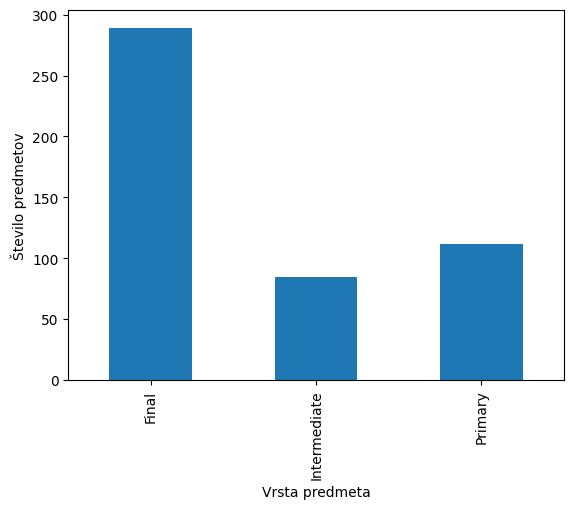

In [16]:
csv_extr = pd.read_csv("data/extracted.csv").sort_values("Item").sort_values("Position", ascending=False)
graf = csv_extr.groupby("Position").size().plot.bar(xlabel="Vrsta predmeta", ylabel="Število predmetov")

Iz grafa vidimo, da je večina predmetov kočnih in nekoliko več primarnih kot vmesnih.

Poglejmo si še pogostost dolžin verig:

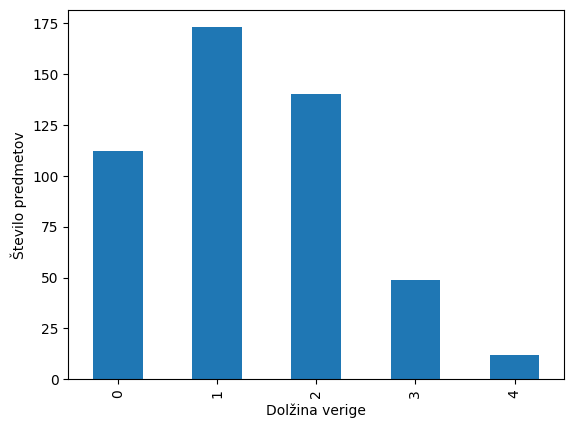

In [17]:
graf = csv_extr.groupby("Chain").size().plot.bar(xlabel="Dolžina verige", ylabel="Število predmetov")

To izgleda približno naravno razporejeno.

Oglejmo si še, koliko predmetov je material za koliko drugih predmetov:

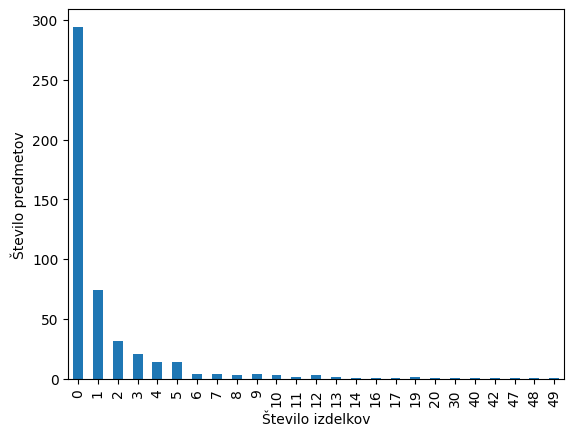

In [18]:
graf = csv_extr.groupby("Craft_Count").size().plot.bar(xlabel="Število izdelkov", ylabel="Število predmetov")

Vidimo dve zanimivosti:
1. Skoraj 300 predmetov ni material za noben drug predmet, kar se ujema z grafom od prej, ki kaže, da je skoraj 300 predmetov končnih,
2. Vsaj en predmet je material za kar 49 drugih predmetov!

Poglejmo si, kateri predmeti to so in za katere predmete so materiali.

In [19]:
master_ingredient = csv_extr[csv_extr.Craft_Count == 49].values[0]
crafts = master_ingredient[4].split(";")
out = master_ingredient[0] + ": "
for craft in crafts:
    out += craft + ", "
print(out[:-2])

Bamboo: Fence_Gate, Dispenser, Bow, Soul_Lantern, Sign, Trapped_Chest, Redstone_Repeater, Soul_Torch, Scaffolding, Spectral_Arrow, Lever, Hoe, Tripwire_Hook, Stick, Tipped_Arrow, Glow_Item_Frame, Swords, Arrow, Redstone_Torch, Crossbow, Torch, Shovel, Wooden_Fence, Campfire, Ladder, Banner, Stone_Hoe, Powered_Rail, Stone_Pickaxe, Stone_Shovel, Rail, Diamond_Sword, Jack_o'Lantern, Painting, Sparkler, Redstone_Comparator, Brush, Activator_Rail, Fishing_Rod, Pickaxe, Warped_Fungus_on_a_Stick, Item_Frame, Carrot_on_a_Stick, Wooden_Axe, Grindstone, Soul_Campfire, Lantern, Axe, Armor_Stand


Poglejmo še, koliko predmetov ima koliko primarnih materialov:

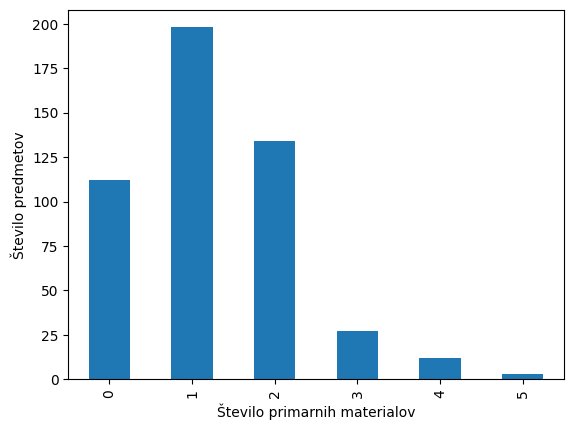

In [20]:
graf = csv_extr.groupby("Ingredient_Count").size().plot.bar(xlabel="Število primarnih materialov", ylabel="Število predmetov")

Spet si oglejmo, kateri predmeti imajo pet primarnih materialov:

In [21]:
master_craft = csv_extr[csv_extr.Ingredient_Count == 5].values[0]
ingredients = master_craft[2].split(";")
out = master_craft[0] + ": "
for ingredient in ingredients:
    out += ingredient + ", "
print(out[:-2])

Sticky_Piston: Cobblestone, Iron_Ingot, Oak_Planks, Redstone_Dust, Slimeball
